In [ ]:
import os
import numpy as np
import random
import string
from matplotlib import pyplot as plt
import matplotlib

In [ ]:
import cv2

In [83]:
def make_timeline(past):
    vals = np.array(past)
    vals[:, 2] = 1

    # print(np.vstack([[vals[0]], vals[np.sum(vals != vals[0], axis=1).astype(bool)]]))

    vals = np.vstack([[vals[0]], vals[np.sum(vals != vals[0], axis=1).astype(bool)]])

    # print(vals)

    x = vals[:, 0]
    y = vals[:, 1]
    z = vals[:, 2]

    first_x = 0
    end_x = min(int(x.shape[0]/5)+1,x.shape[0]-1)

    line_rot = np.arctan((y[end_x]-y[first_x]) /
                         (x[end_x]-x[first_x]+1e-9)) * 180/np.pi


    if x[end_x]-x[first_x] < 0:
        line_rot += 180
    elif x[end_x] == x[first_x] and y[first_x]-y[end_x] < 0:
        line_rot += 180

    rot = matplotlib.transforms.Affine2D().rotate_deg(90-line_rot)

    fig = plt.figure()

    points = vals[:, :3]
    points[:, 2] = 1

    temp_out = rot.transform(points[:, :2])

    x = -temp_out[:, 0]
    y = temp_out[:, 1]

    plt.plot(x, y, color='black')

    y_min = np.min([y[0]-20, np.min(y)-10])
    y_max = np.max([y[0]+80, np.max(y)+10])

    x_size = np.max([50, np.max(x)-x[0]+10, x[0]-np.min(x)+10])
    x_min = x[0]-x_size
    x_max = x[0]+x_size

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.gca().set_aspect('equal')
    plt.axis('off')

    fig.canvas.draw()
    timeline = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    timeline = timeline.reshape(fig.canvas.get_width_height()[::-1]+(3,))
    plt.close()
    timeline = timeline[:, :, 0].astype(np.float32)/255
    timeline = 1-timeline
    return timeline

In [177]:
def world_to_pixel(K, rgb_matrix, destination,  curr_position):

    point_3d = np.ones((4, destination.shape[1]))
    point_3d[0] = destination[0]
    point_3d[1] = destination[1]
    point_3d[2] = curr_position[2]

    # point_3d = np.array([destination[0], destination[1], curr_position[2], 1])
    point_3d = np.round(point_3d, decimals=2)
    # print("3D world coordinate: ", point_3d)

    cam_coords = rgb_matrix @ point_3d
    # cam_coords = rgb_matrix @ point_3d[:, None]
    cam_coords = np.array([cam_coords[1], cam_coords[2]*-1, cam_coords[0]])

    cam_coords = cam_coords[:, cam_coords[2, :] > 0]
    points_2d = np.dot(K, cam_coords)

    points_2d = np.array([
        points_2d[0, :] / points_2d[2, :],
        points_2d[1, :] / points_2d[2, :],
        points_2d[2, :]]
    )
    points_2d = points_2d.reshape(3, -1)
    points_2d = np.round(points_2d, decimals=2)
    return points_2d


In [178]:
def gen_mask(K,inverse_matrix,target_coordinate,float_coordinate,size):
    w,h = size
    im = np.zeros((size[1],size[0]))

    x_offsets = np.linspace(-2, 2, num=150)
    y_offsets = np.linspace(-2, 2, num=150)
    X, Y = np.meshgrid(x_offsets, y_offsets)

    mesh_mask = np.where(X**2+Y**2<=4)

    mesh = np.dstack([X[mesh_mask], Y[mesh_mask]])

    mesh = mesh.reshape(-1, 2)

    mesh = np.hstack([mesh, np.zeros((mesh.shape[0], 1))]).T

    annotations = world_to_pixel(
        K, inverse_matrix, target_coordinate.reshape(3, 1)+mesh, float_coordinate).T

    for i in range(annotations.shape[0]):
        x = round(annotations[i, 0])
        y = round(annotations[i, 1])
        if x < 0 or x >= w or y < 0 or y >= h:
            continue
        # import pdb; pdb.set_trace()
        im = cv2.circle(im, (int(x), int(y)), 4,
                        (255), thickness=-1)
    return im

In [179]:
def to_video(images_folder,annotations_folder,positions_file,video_file,fps=30):
    try:
        frames = sorted(os.listdir(images_folder))
    except Exception as e:
        print(e)
        return
    
    if len(frames)==0:
        return

    past = np.loadtxt(positions_file,delimiter=',').tolist()
    
    frame_count = 0
    im = cv2.imread(os.path.join(images_folder,frames[0]))
    size = (im.shape[1],im.shape[0])

    kernel = np.ones((10, 10), np.uint8)

    idx = 0

    h_offset = 10
    v_offset = 10
    context_size = (320,240)


    try:
        result = cv2.VideoWriter(video_file,cv2.VideoWriter_fourcc(*'MJPG'),fps,size)
        for frame_count, frame in enumerate(frames):
            print('\r'+os.path.join(images_folder,frame),end='')
            
            im = cv2.imread(os.path.join(images_folder,frame))
            im = cv2.resize(im,size)
            mask = cv2.imread(os.path.join(annotations_folder,frame))
            mask = cv2.cvtColor(cv2.resize(mask,size),cv2.COLOR_BGR2GRAY)
            
            # context = cv2.imread(os.path.join(context_folder,frame))
            # context = cv2.dilate(context, kernel, iterations=1)

            context = make_timeline(past[:idx+1])*255
            context = cv2.cvtColor(cv2.resize(context,context_size),cv2.COLOR_GRAY2RGB)
            # plt.imshow(context,cmap='gray')
            # plt.show()

            im[mask>0,:] = 0
            im[mask>0,1] = 255

            im[v_offset:v_offset+context.shape[0],h_offset:h_offset+context.shape[1],:] = context
            
            
            if frame_count == 0:
                plt.imshow(cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
                plt.show()
            result.write(im)
            
            cv2.imshow('frames', im)

            idx += 1

            # break
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except Exception as e:
        print(e)
        raise(e)
    finally:
        result.release()
        cv2.destroyAllWindows()

In [ ]:
def to_video_nomask(images_folder,inverse_mat_folder,target_file,positions_file,intrinsic_file,video_file,fps=30):
    try:
        frames = sorted(os.listdir(images_folder))
    except Exception as e:
        print(e)
        return
    
    if len(frames)==0:
        return

    past = np.loadtxt(positions_file,delimiter=',').tolist()
    target_coordinates = np.loadtxt(positions_file,delimiter=',')
    float_coordinates = np.array(past)

    K = np.load(intrinsic_file)


    
    frame_count = 0
    im = cv2.imread(os.path.join(images_folder,frames[0]))
    size = (im.shape[1],im.shape[0])

    kernel = np.ones((10, 10), np.uint8)

    idx = 0

    h_offset = 10
    v_offset = 10
    context_size = (320,240)


    try:
        result = cv2.VideoWriter(video_file,cv2.VideoWriter_fourcc(*'MJPG'),fps,size)
        for frame_count, frame in enumerate(frames):
            print('\r'+os.path.join(images_folder,frame),end='')
            
            im = cv2.imread(os.path.join(images_folder,frame))
            im = cv2.resize(im,size)

            inverse_matrix = np.load(os.path.join(inverse_mat_folder,  frame+'.npy'))

            mask = gen_mask(K,inverse_matrix,target_coordinates[idx],float_coordinates[idx],size)

            mask = cv2.cvtColor(cv2.resize(mask,size),cv2.COLOR_BGR2GRAY)

            print(mask)
            
            # context = cv2.imread(os.path.join(context_folder,frame))
            # context = cv2.dilate(context, kernel, iterations=1)

            context = make_timeline(past[:idx+1])*255
            context = cv2.cvtColor(cv2.resize(context,context_size),cv2.COLOR_GRAY2RGB)
            # plt.imshow(context,cmap='gray')
            # plt.show()

            im[mask>0,:] = 0
            im[mask>0,1] = 255

            im[v_offset:v_offset+context.shape[0],h_offset:h_offset+context.shape[1],:] = context
            
            
            if frame_count == 0:
                plt.imshow(cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
                plt.show()
            result.write(im)
            
            cv2.imshow('frames', im)

            idx += 1

            # break
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except Exception as e:
        print(e)
        raise(e)
    finally:
        result.release()
        cv2.destroyAllWindows()

In [163]:
base_folder = 'E:/icra video/all'

In [164]:
folders = [ str(x) for x in sorted([ int(x) for x in os.listdir(base_folder)])]
# 30 2
# folders = ['2']
# folders

In [165]:
for folder in folders:
    if 'video.mp4' in os.listdir(os.path.join(base_folder,folder)):
        print(f'{folder} already processed')
        continue

    if 'masks' not in os.listdir(os.path.join(base_folder,folder)):
        print(f'{folder} doesn\'t have masks')
        continue

    if len(os.listdir(os.path.join(base_folder,folder,'images'))) != len(os.listdir(os.path.join(base_folder,folder,'masks'))):
        print(f'{folder} incomplete masks')
        continue


    with open(os.path.join(base_folder,folder,'command.txt')) as f:
        lines = f.readlines()
        print(lines)
    to_video(os.path.join(base_folder,folder,'images'),
             os.path.join(base_folder,folder,'masks'),
             os.path.join(base_folder,folder,'vehicle_positions.txt'),
             os.path.join(base_folder,folder,'video.mp4'),
            fps=10)

1 already processed
5 already processed
9 already processed
11 already processed
13 already processed
16 already processed
20 already processed
27 already processed
29 already processed
30 already processed
31 already processed
34 already processed
56 already processed
57 already processed
60 already processed


In [157]:
def gradient_vertical(height,width,color1,color2,gamma=2):
    arr = np.tile(np.expand_dims(np.arange(height),axis=(1,2)),(1,width,3))
    col1_im = color1*np.ones((height,width,3))
    col2_im = color2*np.ones((height,width,3))
    
    col1_im = (col1_im)**(1/gamma)
    col2_im = (col2_im)**(1/gamma)
    
    arr = (arr*col1_im + (height-arr)*col2_im)/(height)
    arr = arr**gamma
    
    arr = arr.astype(np.uint8)
    
    return arr


In [ ]:
for folder in folders:
    if 'video.mp4' in os.listdir(os.path.join(base_folder,folder)):
        print(f'{folder} already processed')
        continue


    if len(os.listdir(os.path.join(base_folder,folder,'images'))) != len(os.listdir(os.path.join(base_folder,folder,'masks'))):
        print(f'{folder} incomplete masks')
        continue


    with open(os.path.join(base_folder,folder,'command.txt')) as f:
        lines = f.readlines()
        print(lines)
    to_video_nomask(os.path.join(base_folder,folder,'images'),
             os.path.join(base_folder,folder,'masks'),
             os.path.join(base_folder,folder,'vehicle_positions.txt'),
             os.path.join(base_folder,folder,'video.mp4'),
            fps=10)

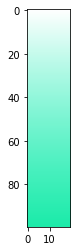

In [159]:
plt.imshow(gradient_vertical(100,20,np.array([0x1C,0xEB,0xA9]),np.array([255,255,255]),1.5))

In [174]:
x_offsets = np.linspace(-2, 2, num=150)
y_offsets = np.linspace(-2, 2, num=150)
X, Y = np.meshgrid(x_offsets, y_offsets)

mesh_mask = np.where(X**2+Y**2<=4)

mesh = np.dstack([X[mesh_mask], Y[mesh_mask]])

mesh = mesh.reshape(-1, 2)

mesh = np.hstack([mesh, np.zeros((mesh.shape[0], 1))]).T

In [175]:
mesh

array([[-0.30872483, -0.28187919, -0.25503356, ...,  0.25503356,
         0.28187919,  0.30872483],
       [-1.97315436, -1.97315436, -1.97315436, ...,  1.97315436,
         1.97315436,  1.97315436],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [176]:
mesh.shape

(3, 17420)

In [ ]:
22500